METACARPA simulation
=================

 The root of all simulations is in `/lustre/scratch114/projects/helic/checkpoints/metacarpa_sim`. Scripts were first written in `/nfs/team144/Arthur-Kallia/metacapa_sim/` but the directory turned out to be too small.

## Under the null

### Principle

#### Getting simulated meta-analysis
The simulation consists of 2 scripts, the simulator itself [simulate.sh](simulate.sh) and the runner [simrun.sh](simrun.sh). A simulation is run as follows: 
~~~
    simrun.sh sample_size1 sample_size2 overlap iteration
~~~    
This should be run in a for loop so as to create a number of iterations, like so:

    for i in {1..500}; do echo simrun.sh 2000 2000 100 $i; done | array 1g simrun

`simrun.sh` generated a subdir of the form `2000-2000-100` in which it places subdirectories corresponding to iterations (here, `100`). Due to the high number of files created on the fly, some runs may fail unexpectedly due to various file errors. They can be catched and rerun using:

    grep xited *.o | grep bject | perl -lape 's/.*?\[//;s/\].*//' | while read line; do hsub 2g -I ./tmp.502805.exe $line; done

#### Getting the false positive rate

This uses the [summary.R](summary.R) script. after `cd` in a simulation subdirectory, run something like:

    find -type f -iname 'meta' | while read i; do Rscript --vanilla /nfs/team144/Arthur-Kallia/metacapa_sim/ukhls/summary.R $i; done > 2000-2000-10.false_positives

#### Getting the correlation estimate

This is done very simply by extracting the relevant line from the matrix file:

    for o in 10 100 250 500 1000 1500; do cd 2000-2000-$o; find -type f -iname "*matrix*" | while read f; do head -n3 $f | tail -n1; done > ../2000-2000-$o.correlation; cd -; done

#### False positive rate and influence of MAF filtering
At first, no MAF filtering was applied for the calculation of the relatedness matrix. The results are in the subdir `/lustre/scratch114/projects/helic/checkpoints/metacarpa_sim/andrare`. Then, we run the same code filtering all variants with MAF greater than 5%. This is in the directory `/lustre/scratch114/projects/helic/checkpoints/metacarpa_sim/firsttry`. We repeat all the stats.

In [5]:
import matplotlib
matplotlib.use('Pdf')
from IPython.core.pylabtools import figsize
#import plotly.plotly as py
#py.sign_in('agilly', '2y0t4gwoyw')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab as pylab
from pylab import *
figsize(15,10)
corr =[]
outfiles=["./andrare_results/2000-2000-10.false_positives", "./andrare_results/2000-2000-100.false_positives", "./andrare_results/2000-2000-250.false_positives","./andrare_results/2000-2000-500.false_positives","./andrare_results/2000-2000-1000.false_positives","./andrare_results/2000-2000-1500.false_positives"]
for file in outfiles:
    d=pylab.loadtxt(file)
    corr.append(np.mean(d, axis=0))
corr=np.asarray(corr)
x=np.asarray([10, 100, 250, 500, 1000, 1500], dtype=float)/2000
# Was 121
#sp=plt.subplot(111, axisbg="whitesmoke")
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
xticks(x, ['0.5%', '5%', '12.5%', '25%', '50%', '75%'])
plt.xlabel('Overlap', fontsize=16)
plt.ylabel('type-I error', fontsize=16)
plt.title('False positive rate', fontsize=20)
ylim(ymin=0.049, ymax=0.14)
yticks((0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14))
a=plt.plot(x,corr[:,0], label="Uncorrected $p_{Stouffer}$", alpha=0.4, lw=3)
a=plt.plot(x,corr[:,1], label="Corrected $p_{Stouffer}$", color="orange", alpha=0.4, lw=3)
a=plt.plot(x,corr[:,2], label="Corrected $p_{Wald}$", color="firebrick", alpha=0.4, lw=3)

l=legend(loc="upper left",prop={'size':20,'weight':'bold'})

#corr =[]
#outfiles=["./firsttry_results/2000-2000-10.statistics", "./firsttry_results/2000-2000-100.statistics","./firsttry_results/2000-2000-250.statistics","./firsttry_results/2000-2000-500.statistics","./firsttry_results/2000-2000-1000.statistics","./firsttry_results/2000-2000-1500.statistics",]
#for file in outfiles:
#    d=pylab.loadtxt(file)
#    corr.append(np.mean(d, axis=0))
#corr=np.asarray(corr)
#x=np.asarray([10, 100, 250, 500, 1000, 1500], dtype=float)/2000
#sp=plt.subplot(122, axisbg="whitesmoke")
#plt.grid(True)
#xticks(x, ['0.5%', '5%', '12.5%', '25%', '50%', '75%'])
#plt.xlabel('Overlap')
#plt.ylabel('type-I error')
#plt.title('False positive rate, MAF filtering <5%')
#a=plt.plot(x,corr[:,0], label="Uncorrected $p_{Stouffer}$")
#a=plt.plot(x,corr[:,1], label="Corrected $p_{Stouffer}$")
#a=plt.plot(x,corr[:,2], label="Corrected $p_{Wald}$")

#l=legend(loc="upper left")
#plt.savefig('t1err_300.pdf', format='pdf', dpi=300)
plt.savefig('t1err_400.tif', dpi=400)

The type-I error rate reacts in a similar way to sample overlap in both cases. Howewer we see an inflation of $1\%$ for all three methods when rare variants are included. Both methods correct type-I error rate under sample overlap, and the inverse-variance meta-analysis performs better, keeping it at approximately $7.5\%$.

#### Correlation estimation accuracy

We simulate sample overlaps of $10$, $100$, $250$, $500$, $1000$, $1500$, corresponding to overlaps of $0.5\%$, $5\%$, $12.5\%$, $25\%$, $50\%$ and $75\%$ with a sample size of $2\times2000$. 

### Under the alternative/power analysis

#### Procedure
A fork of the code for the simulation under the null is used, in the same structure as before: the runner [simrun_alt.sh](simrun_alt.sh) and the simulator [simulate_alt.sh](simulate_alt.sh). There are 2 extra arguments, `MAF` and `EFFECT_SIZE`. We use two different scenarios, a rare variant with $MAF=1.15%$ and $\beta=1.2$ (comparable to a low-frequency causal variant like $APOC3-R19X$ for lipids), and a common variant with $MAF=40%$ and $\beta=0.07$ (comparable to a common causal variant for a complex trait, for example the BMI results from the GIANT study, adapted to suit a reduced sample size of $2\times2000$).

We launch it like previously:
    
    for i in {1..500}; do echo ../../code/simrun_alt.sh 2000 2000 1500 $i 0.015 1.2; done | ~/array 1g rare-2k2k1.5k

Then the p-values for all three tests are fetched as follows:

    for i in 10 100 250 500 1500; do cd 2000-2000-$i; find -type f -iname meta | while read m; do b=$(dirname $m); grep -w -m1 $(cut -d' ' -f1 $b/causal.snp) $m; done | cut -f10-12 | egrep -v "^-1" > ../2000-2000-$i.pvalues;cd -; done

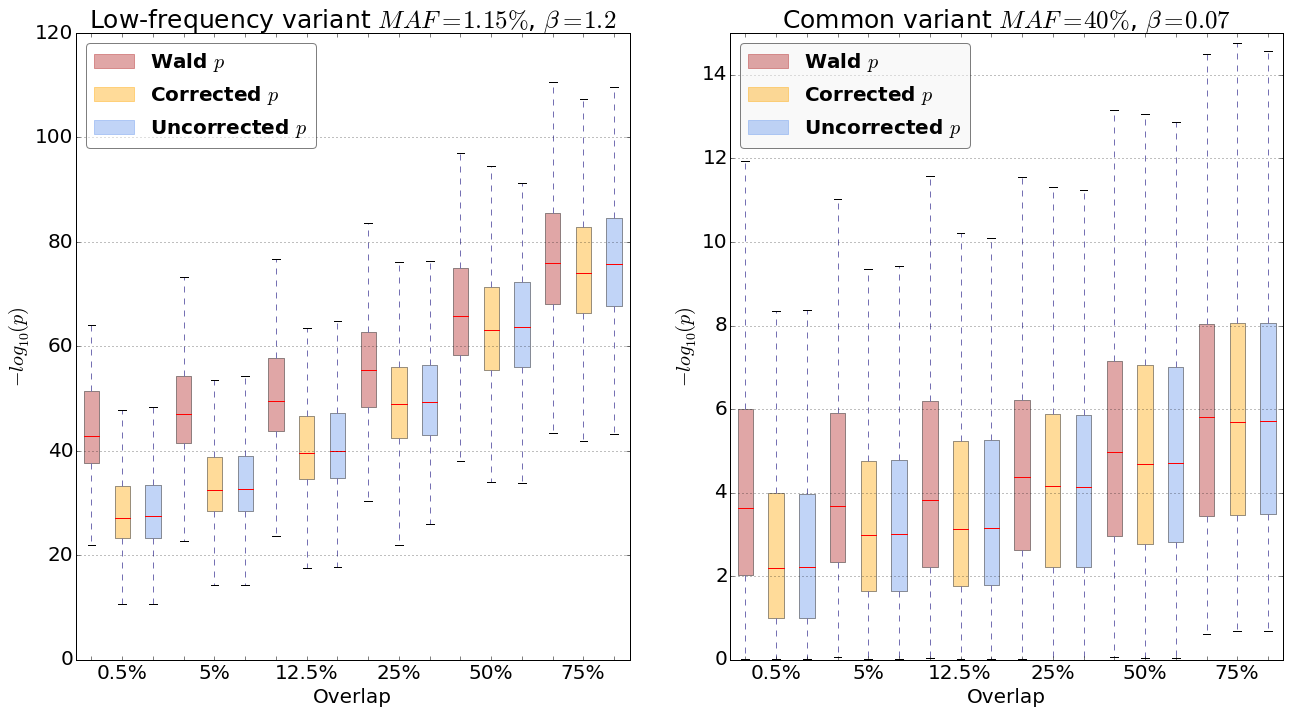

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
#import plotly.plotly as py
#py.sign_in('agilly', '2y0t4gwoyw')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab as pylab
import matplotlib.patches as mpatches
from pylab import *
fig = plt.figure(1, figsize=(18, 10))
ax = fig.add_subplot(121, axisbg="white")
ax.grid(False)
ax.yaxis.grid(True)
#wald = mpatches.Patch(color='bisque', alpha=0.4, label='Wald $p$')
#correct=mpatches.Patch(color = 'gold' ,alpha=0.4, label="Corrected $p$")
#uncorrect=mpatches.Patch(color = 'olive' ,alpha=0.4, label="Uncorrected $p$")
uncorrect=mpatches.Patch(color = 'cornflowerblue' ,alpha=0.4, label="Uncorrected $p$")
correct=mpatches.Patch(color = 'orange' ,alpha=0.4, label="Corrected $p$")
wald = mpatches.Patch(color='firebrick', alpha=0.4, label='Wald $p$')
legend=ax.legend(handles=[wald, correct, uncorrect],loc="upper left",fancybox=True, framealpha=0.5,prop={'size':20,'weight':'bold'})
#legend.get_frame().set_facecolor('whitesmoke')
ylim(0,120)
corr =[]
outfiles=["./power_rare/2000-2000-10.pvalues", "./power_rare/2000-2000-100.pvalues", "./power_rare/2000-2000-250.pvalues", "./power_rare/2000-2000-500.pvalues", "./power_rare/2000-2000-1000.pvalues", "./power_rare/2000-2000-1500.pvalues" ]
for file in outfiles:
    d=pylab.loadtxt(file)
    corr.extend([-log(d[:,0]), -log(d[:,1]), -log(d[:,2])])
#sns.boxplot(corr)
a=ax.boxplot(corr, patch_artist=True)
vlines(3.5, 0,120, color="white")
vlines(6.5, 0,120, color="white")
vlines(9.5, 0,120, color="white")
vlines(12.5, 0,120, color="white")
vlines(15.5, 0,120, color="white")
for i in range(0, len(a['boxes'])):
    if i % 3 == 0: 
        box=a['boxes'][i]
        box.set( facecolor = 'firebrick', alpha=0.4, label="Wald")
    if i % 3 == 1: 
        box=a['boxes'][i]
        box.set( facecolor = 'orange' ,alpha=0.4, label="Corrected")
    if i % 3 == 2: 
        box=a['boxes'][i]
        box.set( facecolor = 'cornflowerblue', alpha=0.4,label="Uncorrected" )
for whisker in a['whiskers']:
    whisker.set(color='#7570b3')
for flier in a['fliers']:
    flier.set(marker='.', color='cornflowerblue', alpha=0)
out=ax.set_xticklabels(['', '0.5%', '', '', '5%', '', '', '12.5%', '', '', '25%', '', '', '50%', '', '', '75%'])
plt.title("Low-frequency variant $MAF=1.15\%$, $\\beta=1.2$", size=25)
plt.xlabel("Overlap", size=20)
plt.ylabel("$-log_{10}(p)$", size=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
corr =[]
outfiles=["./power_common/2000-2000-10.pvalues", "./power_common/2000-2000-100.pvalues", "./power_common/2000-2000-250.pvalues", "./power_common/2000-2000-500.pvalues", "./power_common/2000-2000-1000.pvalues", "./power_common/2000-2000-1500.pvalues" ]
for file in outfiles:
    d=pylab.loadtxt(file)
    corr.extend([-log(d[:,0]), -log(d[:,1]), -log(d[:,2])])
ax = fig.add_subplot(122, axisbg="white")
ax.grid(False)
ylim(0,15)
ax.yaxis.grid(True)
vlines(3.5, 0,15, color="white")
vlines(6.5, 0,15, color="white")
vlines(9.5, 0,15, color="white")
vlines(12.5, 0,15, color="white")
vlines(15.5, 0,15, color="white")
a=ax.boxplot(corr, patch_artist=True)
for i in range(0, len(a['boxes'])):
    if i % 3 == 0: 
        box=a['boxes'][i]
        box.set( facecolor = 'firebrick', alpha=0.4, label="Wald")
    if i % 3 == 1: 
        box=a['boxes'][i]
        box.set( facecolor = 'orange' ,alpha=0.4, label="Corrected")
    if i % 3 == 2: 
        box=a['boxes'][i]
        box.set( facecolor = 'cornflowerblue', alpha=0.4,label="Uncorrected" )
for whisker in a['whiskers']:
    whisker.set(color='#7570b3')
for flier in a['fliers']:
    flier.set(marker='.', color='cornflowerblue', alpha=0)
out=ax.set_xticklabels(['', '0.5%', '', '', '5%', '', '', '12.5%', '', '', '25%', '', '', '50%', '', '', '75%'])
p = mpatches.Patch(color='r', alpha=0.5, linewidth=0)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.title("Common variant $MAF=40\%$, $\\beta=0.07$", size=25)
plt.xlabel("Overlap", size=20)
plt.ylabel("$-log_{10}(p)$", size=20)
plt.tight_layout()
legend=ax.legend(handles=[wald, correct, uncorrect],loc="upper left",fancybox=True, framealpha=0.5,prop={'size':20, 'weight':'bold'})
legend.get_frame().set_facecolor('whitesmoke')
#plt.savefig('power_300.pdf', format='pdf'; dpi=300)
plt.savefig("power_400.tif", dpi=400)

### Comparison of estimators
[Province and Borecki](http://www.ncbi.nlm.nih.gov/pubmed/23424128) propose a correlated p-value based meta-analysis. In short, the method computes tetrachoric correlation between association p-values genome-wide to calculate a "between-study" correlation. In theory, Pearson's correlation of the z-scores could be enough, however this assumes that all p-values are under the null. With a polygenic traits, the number of SNPs under the alternative is potentially high. It is necessary to ignore them, hence the use of tetrachoric correlation.

Tetrachoric correlation is a correlation between binomial restrictions of latent continuous variables. Because it makes a normal assumption, tetrachoric correlation is insensitive to extreme outliers (in our case, positive signal under the alternative). Because the input is binomial, we need to transform our p-values in binomial variables. [Province and Borecki](http://www.ncbi.nlm.nih.gov/pubmed/23424128) suggest the following transformation:

$$
\hat{z_i}=\Phi^{-1}(1-p_i)
$$

and then, compute the correlations of the $b$ where $$b_i=\begin{cases} 0 &\mbox{if }  \hat{z_i} \le 0 \\ 
1 &\mbox{if }  \hat{z_i} > 0. \end{cases}$$
The $\hat{z_i}$ are then meta-analysed for every position by calculating $z_{\mu}=\sum{\hat{z_i}}$ and $p_{\mu}=1-\Phi_{(0, \sigma_z)}(z_{\mu})$. 

This formula will measure the correlation between p-values of overlapping SNPs across studies. For example, if the Wald test is used for testing association between genotype and phenotype, the test statistic will be $\frac{\hat{\beta}}{\hat{\sigma_{\beta}}}$ and the p-value will measure how likely it is to have such a $\hat{\beta}$ given $\hat{\sigma_{\beta}}$. Since the test statistic is symmetrical, it does not matter whether $\hat{\beta}$ is positive or negative, what is tested is the relative size of $|\hat{\beta}|$.
In the case of meta-analysis, it is important to take heterogeneity of effect directions into account. More precisely, the fixed effects model assumes a common underlying effect measured by all studies. Therefore under that hypothesis, significant $\hat{\beta}$ of opposite signs should weaken the meta-analysis signal.

The Stouffer uncorrelated meta-analysis is typically used to take the direction of effects into account:

$$
\hat{z_i}=\Phi^{-1}(\frac{p_i}{2})\times sgn(\beta_i)
$$

The $\hat{z_i}$ are then weighted with $w_i=\frac{\sqrt{N_i}}{\sqrt{\sum{w_i}}}$ and then meta-analysed with:

$$
z_{\mu}=\sum{\hat{z_i}\times w_i}
$$
and converted back to p-values with $p_{\mu}=2\Phi(-|z_{\mu}|)$.
This method is uncorrected. We derive the equivalent usage of [Province and Borecki](http://www.ncbi.nlm.nih.gov/pubmed/23424128)'s method. The only difference in the case of related studies is that $Var(z_{\mu})\ne 1$. We have:

$$
Var(z_{\mu})=\sum{w_i^2 Var(z_i)}+2\sum_{k>l} w_kw_lCov(z_k, z_l)
$$

The first term sums to $1$, the second term is dependent on $Cov(z_l, z_l)=\sigma_{z_l}\sigma_{z_k}\times corr(z_k, z_l)$. The first two terms on the left hand side are $1$ by construction. We are left with the correlation, which we set equal to te tetrachoric $\rho$ discussed earlier. Only now, the sign of $\hat{z_i}$ is determined by $sgn(\beta_i)$. In other words, we are correlating the directions of effect across studies to be meta-analysed.

We compare the full-fledged computation of $sgn(\Phi^{-1}(\frac{p_i}{2})\times sgn(\beta_i))$ versus $sgn(\beta_i)$ (should be equal). We also wanted to test whether keeping a measure of the significance of the p-value as well as the coherence in directions of effect improves the measure of correlation. For this, we implement the alternative transformation:
$$
b_i=\begin{cases} 0 &\mbox{if }  \hat{z_i} \le \Phi(0.25) \\ 
1 &\mbox{if }  \Phi(0.25) < \hat{z_i} \le \Phi(0.5)=0 \\
2  &\mbox{if }  0 < \hat{z_i} \le  \Phi(0.75)\\
3  &\mbox{if }  \hat{z_i} > \Phi(0.75).
\end{cases}
$$
We then use polychoric correlation. Code follows:
```r
## CD into directory
## Run R script
library(data.table)
d1=fread("group1.qassoc")
d2=fread("group2.qassoc")
library(psych)
da=merge(d1,d2,by="SNP")
s1=sign(da$BETA.x)
s2=sign(da$BETA.y)
s2[s2==-1]=0
s1[s1==-1]=0
r=tetrachoric(table(s1,s2))$rho
s1=qnorm(1-da$P.x/2)*sign(da$BETA.x)
s2=qnorm(1-da$P.y/2)*sign(da$BETA.y)
s1=sign(s1)
s2=sign(s2)
s2[s2==-1]=0
s1[s1==-1]=0
r[2]=tetrachoric(table(s1,s2))$rho
s1=qnorm(1-da$P.x/2)*sign(da$BETA.x)
s2=qnorm(1-da$P.y/2)*sign(da$BETA.y)
s1[s1>qnorm(0.75)]=3
s1[s1>0 & s1 <= qnorm(0.75)]=2
s1[s1<=0 & s1 > qnorm(0.25)]=1
s1[s1 <= qnorm(0.25)]=0
s2[s2>qnorm(0.75)]=3
s2[s2>0 & s2 <= qnorm(0.75)]=2
s2[s2<=0 & s2 > qnorm(0.25)]=1
s2[s2 <= qnorm(0.25)]=0
p=polychoric(cbind(s1,s2))
r[3]=p$rho[2,1]
print(r)
```

There is no single-step continuous estimator for polychoric correlation. If polychoric correlation turns out to be the most sensitive to true sample overlap, then a significant performance impact will be felt (see "Convergence of estimator").

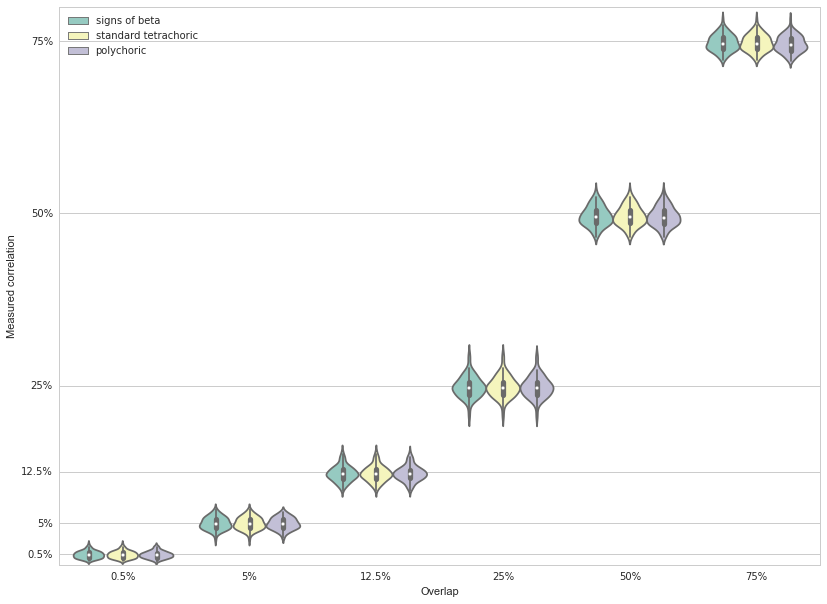

In [13]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab as pylab
import matplotlib.patches as mpatches
from pylab import *
import pandas as pd
fig = plt.figure(1, figsize=(30, 10))
ax = fig.add_subplot(121, axisbg="white")
ax.grid(False)
ax.yaxis.grid(True)
import seaborn as sb
sb.set_style("whitegrid")
from __future__ import division
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_DOWN

corr=[]
id=[]
percentage_overlap=[]
overlaps=[10, 100, 250, 500, 1000, 1500]
i=0
outfiles=["correlations/2000-2000-10.correlations.clean", "correlations/2000-2000-100.correlations.clean", "correlations/2000-2000-250.correlations.clean", "correlations/2000-2000-500.correlations.clean", "correlations/2000-2000-1000.correlations.clean", "correlations/2000-2000-1500.correlations.clean"]
for file in outfiles:
    d=pylab.loadtxt(file)
    corr.extend(d[:,0])
    corr.extend(d[:,1])
    corr.extend(d[:,2])
    id.extend(full(100,'signs of beta', dtype='a20'))
    id.extend(full(100,'standard tetrachoric', dtype='a20'))
    id.extend(full(100, 'polychoric', dtype='a20'))
    percentage_overlap.extend(full(300, overlaps[i], dtype='i'))
    i=i+1

#ind=np.zeros((297*6,),dtype=('f5,a20,i5'))
#ind[:]=zip(corr,id,percentage_overlap)
#d=pd.DataFrame(ind)
with sb.color_palette("Set3"):
    s=sb.violinplot(y=corr, hue=id, x=percentage_overlap,cmap="colorblind")
    plt.xlabel("Overlap")
    plt.ylabel("Measured correlation")
    xticks([0,1,2,3,4,5], ['0.5%', '5%', '12.5%', '25%', '50%', '75%'])
    yticks([0.005, 0.05, 0.125, 0.25, 0.5, 0.75], ['0.5%', '5%', '12.5%', '25%', '50%', '75%'])
    ylim(-0.01,0.8)
#sb.violinplot(ind)
#u=np.zeros()
#corr=map(list, zip(*corr))
#corr.view(dtype=zip(('signs of beta', 'full transformation', 'polychoric')))
#shape(corr)

As expected, the two first methods yield the same result. More surprisingly, the polychoric correlation estimate does not produce a more sensible estimate and instead yields very similar results.

### Convergence of estimator

The traditional estimator for tetrachoric correlation is a maximum-likelihood iterative procedure. Instead of going down that lane, we took the easier route of using the approximtion of [Digby (1983)](http://www.jstor.org/stable/2531104), which is simply:

$$
\hat{\rho}=\frac{\alpha-1}{\alpha+1}
$$

where $\alpha=\left(\frac{n_{00}n_{11}}{n_{01}n_{10}}\right)^{\frac{\pi}{4}}$. This is one of the fast estimators found in STATA, and according to its author, performs well with large $n$. We compare the standard errors and convergence script for this approximation versus the two-step estimator implemented in R. We use the [getConvergence.R](getConvergence.R) script to fetch data for individual runs. It randomly selects increasing amounts of SNPs and computes their tetrachoric correlation using R's ML estimator and Digby's approximation. The script is run in the following way and then the results collated:

```bash
for j in 10 100 250 500 1000 1500; do for i in {1..300}; do echo /software/bin/Rscript --vanilla ./getConvergence.R 2000-2000-$j/$i; done; done | ~/array 1g getconv yesterday
#for some reason the variant count varies, so the last (61th) iteration is not always present.
paste -d ' ' 2000-2000-10*ml | head -n-1 > 2000-2000-10.ml.convergence.results
```

We also include Pearson's coefficient for good measure, as it is mentioned in [Zhu et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0002929714004777).

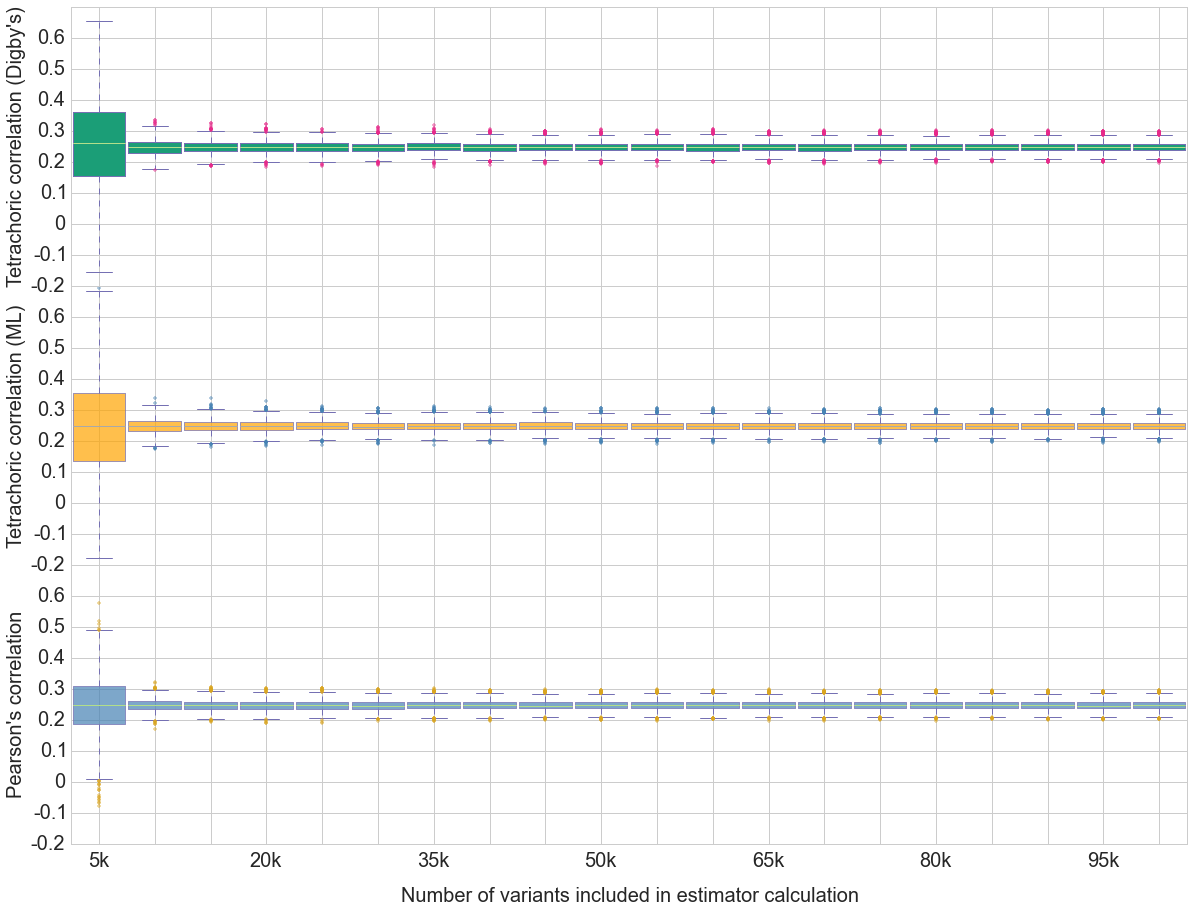

In [71]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pylab as pylab
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from pylab import *
overlap=str(500)
approx=pylab.genfromtxt("convergence_results/2000-2000-"+overlap+".approx.convergence.results", skip_footer=40)
ml=pylab.genfromtxt("convergence_results/2000-2000-"+overlap+".ml.convergence.results", skip_footer=40)
pearson=pylab.genfromtxt("convergence_results/2000-2000-"+overlap+".zhu.convergence.results", skip_footer=40)

fig, (ax, ax2, ax3) = plt.subplots(3, figsize=(20,15), sharex=True, sharey=True)
figsize(20,15)
matplotlib.rcParams.update({'font.size': 16})
bp = ax.boxplot(approx.transpose(), patch_artist=True, widths=0.94)
ylim(-0.2, 0.7)
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=1)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=1)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=1)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='.', color='#e7298a', alpha=0.5)
u=ax.set_xticklabels([s + "k" for s in [ str(s) for s in range(5, 300, 5)]])
u=ax.set_yticklabels(['-0.2','-0.1','0','0.1','0.2','0.3', '0.4','0.5','0.6'])
ax.set_ylabel("Tetrachoric correlation (Digby's)", size=20)
i=0
for label in ax.get_xticklabels() :
    if i % 3 != 0:
        label.set_visible(False)
    i=i+1

#ax2=fig.add_subplot(212, sharex=ax)
bp = ax2.boxplot(ml.transpose(), patch_artist=True, widths=0.94)
ax2.set_ylabel("Tetrachoric correlation (ML)", size=20)
for box in bp['boxes']:
    box.set( color='#7570b3', linewidth=1)
    box.set( facecolor = 'orange' ,alpha=0.7)
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=1)
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)
for median in bp['medians']:
    median.set(color='darkgrey', linewidth=1)
for flier in bp['fliers']:
    flier.set(marker='.', color='steelblue', alpha=0.5)
#ax2.xaxis.tick_top()
i=0

u=plt.ylabel("Pearson's correlation", size=20)
bp=ax3.boxplot(pearson.transpose(), patch_artist=True, widths=0.94)
fig.subplots_adjust(hspace=0)
u=ax3.set_xticklabels([s + "k" for s in [ str(s) for s in range(5, 300, 5)]])
for label in ax3.get_xticklabels() :
    if i % 3 != 0:
        label.set_visible(False)
    i=i+1
for box in bp['boxes']:
    box.set( color='#7570b3', linewidth=1)
    box.set( facecolor = 'steelblue' ,alpha=0.7)
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=1)
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=1)
for flier in bp['fliers']:
    flier.set(marker='.', color='goldenrod', alpha=0.5)
u=plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
u=ax3.set_xlabel("Number of variants included in estimator calculation", size=20, labelpad=16)

The two estimators have extremely similar patterns of convergence; for both of them, the variance of the estimator decreases rapidly when more and more variants are randomly added to the tetrachoric calculation. After $30000$ variants, further additions do not seem to improve the estimator.

* By how much should the data be thinned down to get an accurate estimate ?

We expect this value to be dependent on the platform, since it will be influenced by linkage disequilibrium among the typed variants. This number of $30000$, which corresponds to a $\frac{1}{10}$ thinning, is valid for `CoreExome` data, thinning should probably be less stringent for `OmniExpress`, and more so for sequencing data.

### Accuracy of tetrachoric correlation

In the previous section, we showed that the polychoric estimate of correlation was similar to the tetrachoric one. We also showed that Digby's approximation converges as fast, and is as accurate, as the ML estimator implemented in popular packages such as R.

Here, we focus on the accuracy of our estimate when compared to the real correlation. This correlation is known because the studies were simulated with a known overlap. For context, we also display Pearson's correlation of the test statistics, which is implemented in other meta-analysis packages such as [Zhu's](http://www.sciencedirect.com/science/article/pii/S0002929714004777).

#### Technical note:
In order to get more accurate distributions we used the directory `/lustre/scratch114/projects/helic/checkpoints/metacarpa_sim/andrare`, which contains 300 iterations instead of the 100 ones in the main directory. The script [getcorrelationsPearson.sh](getcorrelationsPearson.sh) was used in the now familiar loop:
```bash
    for j in 10 100 250 500 1000 1500; do for i in {1..300}; do echo ./getcorrelationPearson.sh 2000-2000-$j/$i; done; done | ~/array 1g getconv
```

In [24]:
%load_ext rpy2.ipython

In [23]:
%%R -w 1000
#pdf("accuracy.pdf", width=10)
tiff("accuracy.tiff", res=400, width=12, height=10, units='in')
library(grDevices)
makeTransparent = function(coul, alpha=0.5) {
  alpha = floor(255*alpha)  
  col = col2rgb(coul, alpha=FALSE)

    return(rgb(red=col[1], green=col[2], blue=col[3], alpha=alpha, maxColorValue=255))
  }

filebase=c(10, 100, 250, 500, 1000, 1500)
par(mfrow=c(2,length(filebase)/2), mar=c(4,0,0,0))
i=1
firstbar_y=0.7
secondbar_y=0.67
bar_height=0.02
for (base in filebase) {
    d=read.table(paste("correlation_error/2000-2000-", base, ".correlation", sep=""))
    q=quantile(d$V1, c(0, 0.2, 0.4, 0.6, 0.8, 1))
    e=read.table(paste("correlation_error/2000-2000-", base, ".pearson", sep=""))
    p=quantile(e$V1, c(0, 0.2, 0.4, 0.6, 0.8, 1))
    plot(0, xlim=c(min(c(q,p)), max(c(q,p))), ylim=c(secondbar_y-2*bar_height, firstbar_y+3*bar_height), type="n", xlab="", ylab="", axes=F)
    if(i==1){
        legend(x=min(c(q,p)), y=firstbar_y+3.5*bar_height, 
               fill=c("blue", "forestgreen"), legend=c("Digby's tetrachoric", "Pearson's"), cex=2, ncol=1, bty="n")
    }
    axis(1, at=c(q[c(1,6)], quantile(d$V1, 0.5), base/2000), labels=round(c(q[c(1,6)], quantile(d$V1, 0.5), base/2000), 3), las=2, cex.axis=1.4)
    abline(v=base/2000, lty="dashed", col="darkgrey")
    rect(q[1], firstbar_y, q[6], firstbar_y+bar_height, col=makeTransparent("blue", 0.2), border=NA)
    rect(q[2], firstbar_y, q[5], firstbar_y+bar_height, col=makeTransparent("blue", 0.5), border=NA)
    rect(q[3], firstbar_y, q[4], firstbar_y+bar_height, col=makeTransparent("blue", 0.6), border=NA)
    lines(c(quantile(d$V1, 0.5),quantile(d$V1, 0.5)), c(firstbar_y*1.001,firstbar_y+bar_height*0.99),lwd=1)
    
    q=p
    rect(q[1], secondbar_y, q[6], secondbar_y+bar_height, col=makeTransparent("forestgreen", 0.2), border=NA)
    rect(q[2], secondbar_y, q[5], secondbar_y+bar_height, col=makeTransparent("forestgreen", 0.5), border=NA)
    rect(q[3], secondbar_y, q[4], secondbar_y+bar_height, col=makeTransparent("forestgreen", 0.6), border=NA)
    lines(c(quantile(e$V1, 0.5),quantile(e$V1, 0.5)), c(secondbar_y*1.001,secondbar_y+bar_height*0.99),lwd=2)

    i=i+1
}

dev.off()

quartz_off_screen 
                2 



We see that the standard Pearson's correlation is a more accurate estimator of overlap in our simulation setting (the same than for the paragraph "Under the null"). We expect that under strong polygenic signal, tetrachoric correlation will remain stable, as opposed to Pearson's correlation which is expected to rise.



### Simulation under polygenic signal

In order to test the robustness of the correlation estimate under strong polygeny, we use a simulation model for the phenotype that assigns an arbitrary number of variants $M$ effect sizes that together explain a portion $h^2$ of the trait heritability. We use the model

$$
y_j=g_j+e_j \mbox{ where } g_j=\sum_{i=1}^M{z_{ij}u_i}
$$

where the $z_{ij}$ are the standardised allele counts $\frac{count_{ij}-\mu_i}{\sigma_i}$, where $2\mu_i=2f_i$,  $\sigma_i=\sqrt{2f_i(1-f_i)}$ and $f$ is the minor allele frequency of variant $i$. $e\sim\mathcal{N}\left(0, \sigma_g\frac{1-h^2}{h^2}\right)$ is the residual error, and if $g_j\sim\mathcal{N}\left(0, \sigma_g=h^2\right)$, then $y_j\sim\mathcal{N}(0,1)$.

$z_{ij}\sim\mathcal{N}(0,1)$ by construction for any given $j$, so in order to guarantee $g_j\sim\mathcal{N}\left(0, h^2\right)$, we need $u_i\sim\mathcal{N}\left(0, \frac{h^2}{M}\right)$.

We can just draw $M$ samples from that distribution and assign them to the effects, but that would ignore the frequency of the variants. We expect that rarer variants will have larger effects and contribute more, whereas common effects should be less consequent. Therefore, we must find a way to associate allele frequencies with effect sizes that are standard-normally distributed, where both tails correspond to rarer variants and the center to more common ones.

We start by looking at the distribution of allele frequencies in our dataset (100k variants chosen randomly with `plink --thin-count 100000` genomewide, in `/lustre/scratch114/projects/helic/checkpoints/metacarpa_sim/polygeny/100k.formaf.traw`).


In [1]:
%load_ext rpy2.ipython

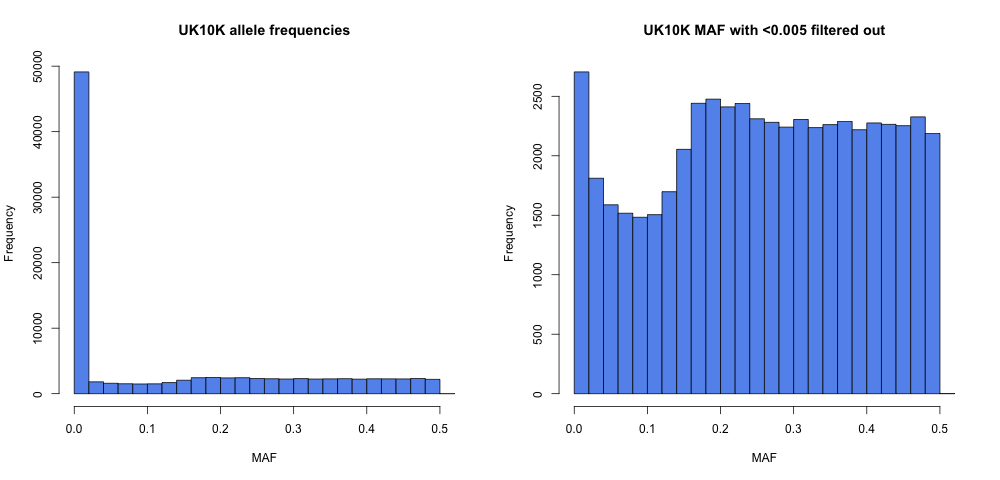

In [35]:
%%R -w 1000 -o d
library(data.table)
d=fread("uk10k.freq/allele.frequencies.uk10k")
d=as.numeric(d$V1)
par(mfrow=c(1,2))
hist(d, breaks=20, main="UK10K allele frequencies", xlab="MAF", col="cornflowerblue")
hist(d[d>0.005], breaks=20, main="UK10K MAF with <0.005 filtered out", xlab="MAF", col="cornflowerblue")

We can choose to consider the filtered distribution on the right as approximately uniform $MAF\sim\mathcal{U}(0.005, 0.5)$ or make no assumption and inverse normalise it.

In the case of an uniform distribution, if $X\sim\mathcal{U}(a,b) \mbox{ where }a>0;b<1$, then $\frac{X-a}{b-a}\sim\mathcal{U}(0,1)$. 
$\DeclareMathOperator\erf{erf}$
Then if $Y=\frac{X-a}{b-a}\sim\mathcal{U}(0,1)$ and $Y\sim\mathcal{U}(0,1)$, then $\sqrt{2}\erf^{-1}(2X-1)\sim\mathcal{N}(0,1)$. THe inverse error function is growing, so the order of the values to be transformed will stay the same, meaning that rare alleles will have a large negative effect, whereas common alleles will have a large positive one, which makes no biological sense. We thus flip the distribution $Y'=0.5-\frac{X-a}{2(b-a)}\sim\mathcal{U}(0,0.5)$. We multiply it by a random variable Z so that $Z=\begin{cases} 1 &p=0.5 \\ 
-1 &p=0.5 \end{cases}$. This gives us $ZY\sim\mathcal{U}(-0.5,0.5)$, so that $ZY+0.5\sim\mathcal{U}(0,1)$ and $\sqrt{2}\erf^{-1}(2ZY)\sim\mathcal{N}(0,1)$. Finally, we just multiply by $\frac{h^2}{M}$ to get $u_i\sim\mathcal{N}\left(0, \frac{h^2}{M}\right)$.<br>
<br>An interesting property of $ZY+0.5$ is that the smaller MAFs are located at both ends of the distribution, a property that is kept when transforming it to normal due to the continuity and growth of the inverse error function.
<br>
<br>
<br>
Alternatively, we can inverse normalise the $ZY$ with Blom's inverse normal $\Phi^{-1}\left(\frac{r_i-c}{N-2c+1}\right)$ where $c=\frac{3}{8}$ and $r_i$ are the ranks of the data.

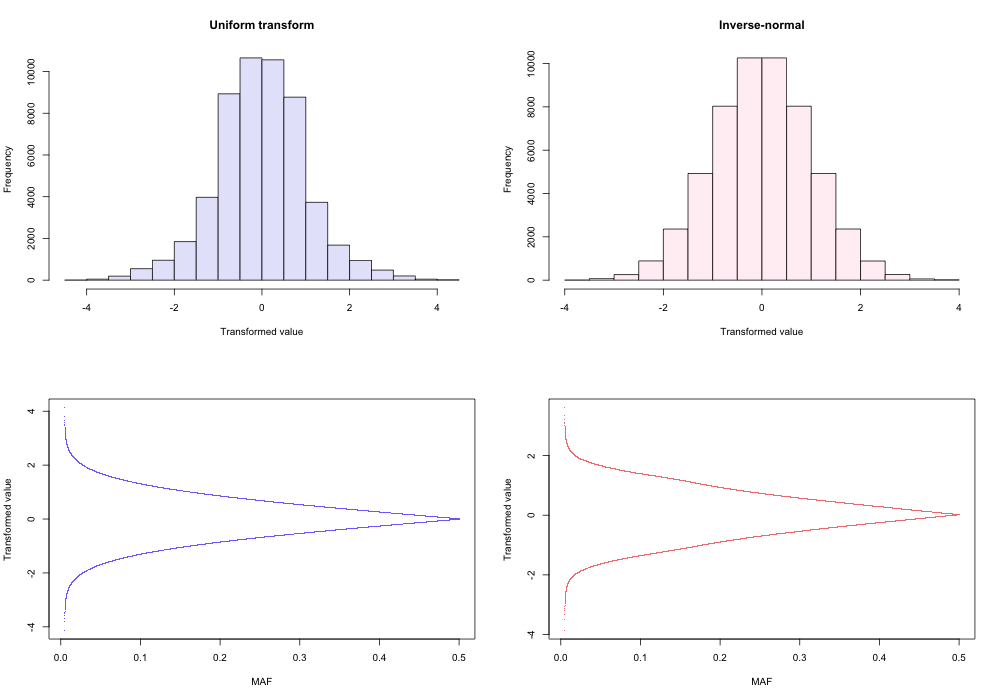

In [51]:
%%R -w 1000 -h 700
d=d[d>0.005]
af=sample(c(-1,1), length(d), replace=T)*(0.5-(d-0.005)/(1-0.005))
erf.inv <- function(x) qnorm((x + 1)/2)/sqrt(2)
    par(mfrow=c(2,2))
hist(sqrt(2)*erf.inv(2*af), main="Uniform transform", xlab="Transformed value", col="lavender")
int=qnorm((rank(af)-0.375)/(length(af)-2*0.375+1))
hist(int, main="Inverse-normal", xlab="Transformed value", col="lavenderblush")
plot(d, sqrt(2)*erf.inv(2*af), pch=".", xlab="MAF", ylab="Transformed value", col="lightslateblue")
plot(d, int, pch=".", xlab="MAF", ylab="Transformed value",col="lightcoral")

We simulate a polygenic signal of 10,000 variants for a trait that is $h^2=10\%$ heritable, under 25% sample overlap.

Script history:
* [`makepheno.R`](makepheno.R)+[`makeassoc.sh`](makeassoc.sh) are the first scripts, which do not normalise genotypes and use random $u_i\sim\mathcal{N}\left(0, \frac{h^2}{M}\right)$;
* [`makepheno_proper.R`](makepheno_proper.R)+[`makeassoc_proper.sh`](makeassoc_proper.sh) are the same, except they normalise genotype counts;
* [`makepheno_maf_normalised_uniform_standard.R`](makepheno_maf_normalised_uniform_standard.R)+[`makeassoc_maf_normalised_uniform_standard.sh`](makeassoc_maf_normalised_uniform_standard.sh) ensure the dependency of effects to minor allele frequencies using the uniform transposition (above left).

To run the simulation, we write:

> `for i in {1..300}; do echo ../simrun_polygeny.sh 2000 2000 500 $i 0.05; done | ~/array 5g polygeny`

Aggregation of results:

* **for Pearson's** : `for i in {1..300}; do echo ./getPearsonSingle.sh $i; done | ~/array 500 pearson yesterday`
* **for tetrachoric** : `find -type f -iname "*matrix*"| while read line; do head -n3 $line | tail -n1; done > tetrachoric.estimate`

In [36]:
%%R -w 1200 -h 500
#pdf("polygenic.pdf", width=12)
# image can not be compressed directly using Quartz
tiff("polygenic.tiff", res=400, width=12, height=5, units='in')
library(grDevices)
makeTransparent = function(coul, alpha=0.5) {
  alpha = floor(255*alpha)  
  col = col2rgb(coul, alpha=FALSE)

    return(rgb(red=col[1], green=col[2], blue=col[3], alpha=alpha, maxColorValue=255))
  }
library(grDevices)
base=500
cols=c("#023FA5","#8E063B")
d=read.table("polygenic/tetrachoric.estimate")
q=quantile(d$V1, c(0, 0.2, 0.4, 0.6, 0.8, 1))
e=read.table("polygenic/pearson.estimate")
p=quantile(e$V1, c(0, 0.2, 0.4, 0.6, 0.8, 1))
firstbar_y=0.7
secondbar_y=0.67
bar_height=0.02
plot(0, xlim=c(min(c(q,p)), max(c(q,p))), ylim=c(secondbar_y-2*bar_height, firstbar_y+3*bar_height), type="n",
     xlab="", ylab="", axes=F)
#legend(x=min(c(q,p)), y=firstbar_y+3*bar_height, fill=c("blue", "forestgreen"), legend=c("Digby's tetrachoric", 
#"Pearson's"), cex=2, ncol=2)
axis(1, at=sort(c(q[c(1,6)], quantile(d$V1, 0.5), quantile(e$V1, 0.5), base/2000)), labels=round(sort(c(q[c(1,6)], 
quantile(d$V1, 0.5), quantile(e$V1, 0.5), base/2000)), 3), las=2, cex.axis=1.4)
abline(v=base/2000, lty="dashed", col="darkgrey")
rect(q[1], firstbar_y, q[6], firstbar_y+bar_height, col=adjustcolor(cols[1], 0.3), border=NA)
rect(q[2], firstbar_y, q[5], firstbar_y+bar_height, col=adjustcolor(cols[1], 0.5), border=NA)
rect(q[3], firstbar_y, q[4], firstbar_y+bar_height, col=adjustcolor(cols[1], alpha=0.6), border=NA)
lines(c(quantile(d$V1, 0.5),quantile(d$V1, 0.5)), c(firstbar_y,firstbar_y+bar_height*0.99),lwd=2)
    q=p
    rect(q[1], secondbar_y, q[6], secondbar_y+bar_height, col=makeTransparent(cols[2], 0.2), border=NA)
    rect(q[2], secondbar_y, q[5], secondbar_y+bar_height, col=makeTransparent(cols[2], 0.5), border=NA)
    rect(q[3], secondbar_y, q[4], secondbar_y+bar_height, col=makeTransparent(cols[2], 0.6), border=NA)
    lines(c(quantile(e$V1, 0.5),quantile(e$V1, 0.5)), c(secondbar_y+0.0005,secondbar_y+bar_height*0.99),lwd=2)
legend(x=0.275, y=secondbar_y-0.005, c("Tetrachoric correlation", "Pearson's correlation"), 
       fill=cols, cex=1.3)
dev.off()

quartz_off_screen 
                2 


We observe a marked increase in the value of the Pearson coefficient (10% inflation), whereas the tetrachoric correlation coefficient manages to correct inflation to 3.2%. Very similar values were observed when heritability was changed from 10% to 5% or 25%.

In [ ]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches

#fig1 = plt.figure()
#ax1 = fig1.add_subplot(111)
#xlim(0, 7)
#plt.vlines([1, 2, 3, 4, 5, 6], 0, 1, colors="darkgrey", linestyles="dashed")
#ax1.add_patch(
#    patches.Rectangle(
#        (0.5, 0.7),   # (x,y)
#        1,          # width
#        0.05,          # height
#    alpha=0.2)
#)
#ax1.add_patch(
#    patches.Rectangle(
#        (0.6, 0.7),   # (x,y)
#        0.8,          # width
#        0.05,          # height
#    alpha=0.2)
#)
#ax1.add_patch(
#    patches.Rectangle(
#        (0.7, 0.7),   # (x,y)
#        0.6,          # width
#        0.05,          # height
#    alpha=0.2)
#)
#ax1.add_patch(
#    patches.Rectangle(
#        (0.8, 0.7),   # (x,y)
#        0.4,          # width
#        0.05,          # height
#    alpha=0.2)
#)


## Power for GWAS paper

It was pointed out that simply reporting a distribution of p-values for the causal SNP is not a proper representation of power. Also, 500 repeats might be too few. We improve power and type-1 error calculations across 1,000 runs.

We also edit the scripts to simulate our signals, which had some flaws.

```bash
for j in 10 40 100 250 500 1000 1500; do for i in {1..1300}; do echo ../../../simrun_alt_local.sh 2000 2000 $j $i 0.2 0.176; done;done | ~/array 1g common
```

We rerun potential hidden failures:

```bash
declare -a a=(10 40 100 250 500 1000 1500)
num=1000;for i in {0..1}; do for ((k=1;k<=num;k++)); do fc=$(ls 2000-2000-${a[$i]}/$k | wc -l); echo $i $k $fc; done; done | awk '$NF<2{print $1*1000+$2}' | tr '\n' ','
```


We exclude SNPs that were by chance selected twice or more:

```bash
for i in 10 40 100 250 500 1000 1500; do 
    cd 2000-2000-$i
    find -type f -iname "causal.snp" | while read line; do 
        cat $line; 
    done | cut -d' ' -f1 | sort | uniq -c | awk '$1>1{print $2}'> excluded.snps
    cd -
done
```

We aggregate our results :

```bash
for i in 10 40 100 250 500 1000 1500; do     cd 2000-2000-$i;     find -type f -iname meta | while read m; do          b=$(dirname $m);          find=$(grep -w -f excluded.snps $b/causal.snp);          if [[ -z $find ]];          then               grep -w -m1 $(cut -d' ' -f1 $b/causal.snp) $m;           fi;     done | cut -f11-14 | egrep -v "^-1" > ../2000-2000-$i.pvalues;     cd - ; done
paste <(head -n1000 2000-2000-10.pvalues) <(head -n1000 2000-2000-40.pvalues) <(head -n1000 2000-2000-100.pvalues) <(head -n1000 2000-2000-150.pvalues) <(head -n1000 2000-2000-200.pvalues) <(head -n1000 2000-2000-250.pvalues) <(head -n1000 2000-2000-500.pvalues) <(head -n1000 2000-2000-1000.pvalues) <(head -n1000 2000-2000-1500.pvalues) > all.extra.pvalues
```


### Under the null

```bash
for j in 10 40 100 250 500 1000 1500; do for i in {1..1000}; do echo ../../../../simrun_null.sh 2000 2000 $j $i ; done;done | ~/array 1g null
for j in 10 40 100 250 500 1000 1500; do for i in {1..1000}; do echo Rscript --vanilla ../../../../summary.R 2000-2000-$j/$i/meta ; done;done | ~/array 1g null.R
```

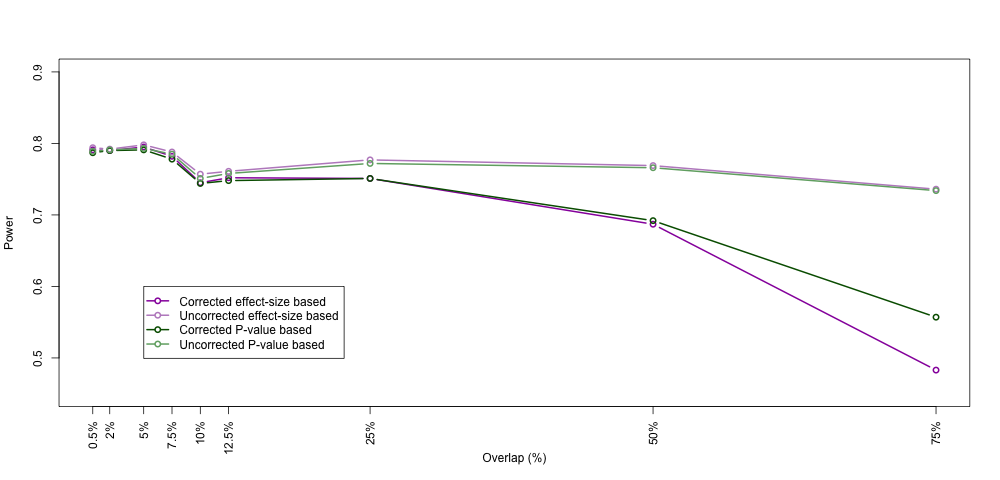

In [18]:
%%R -w 1000
pal=c("#9800AB","#BD8DC7","#71AB72","#005C00")
#pdf("power_extensive_papercolors.pdf", width=10, height=6)
#tiff("pwr.400.new.extended.tiff", res=400, width=10, height=6, units='in')
d=read.table("all.extra.pvalues")
library(data.table)
library(grDevices)
ovlp=c(10, 40, 100, 150, 200, 250, 500, 1000, 1500)
pwr=apply(d, 2, function(x) length(x[x<5e-8 & !is.na(x)])/length(x[!is.na(x)]))
lci=apply(d, 2, function(x) binom.test(length(x[x<5e-8 & !is.na(x)]), length(x[!is.na(x)]))$conf.int[1])
uci=apply(d, 2, function(x) binom.test(length(x[x<5e-8 & !is.na(x)]), length(x[!is.na(x)]))$conf.int[2])
plot(x=ovlp, y=pwr[seq(1, length(pwr), by=4)], type="b", lwd=2, col=pal[1], ylim=c(0.45, 0.9), 
     
     xlab="Overlap (%)", xaxt="n", ylab="Power", main="")
#segments(x0=ovlp, y0=lci[seq(1, length(pwr), by=4)], y1=uci[seq(1, length(pwr), by=4)], lwd=2, col="darkgrey")
lines(x=ovlp, y=pwr[seq(2, length(pwr), by=4)], type="b", lwd=2, col=pal[2])
#segments(x0=ovlp, y0=lci[seq(2, length(pwr), by=4)], y1=uci[seq(2, length(pwr), by=4)], lwd=2, col="darkgrey")
lines(x=ovlp, y=pwr[seq(3, length(pwr), by=4)], type="b", lwd=2, col=pal[4])
#segments(x0=ovlp, y0=lci[seq(3, length(pwr), by=4)], y1=uci[seq(3, length(pwr), by=4)], lwd=2, col="darkgrey")
lines(x=ovlp, y=pwr[seq(4, length(pwr), by=4)], type="b", lwd=2, col=pal[3])
#segments(x0=ovlp, y0=lci[seq(4, length(pwr), by=4)], y1=uci[seq(4, length(pwr), by=4)], lwd=2, col="darkgrey")
axis(1, at=ovlp, labels=c("0.5%", "2%", "5%", "7.5%", "10%", "12.5%", "25%", "50%", "75%"), las=3)
legend(100, 0.6, c("Corrected effect-size based", "Uncorrected effect-size based", "Corrected P-value based", 
                   "Uncorrected P-value based"), col=pal[c(1,2,4,3)], pch=21, pt.bg="white", lwd=2)


#dev.off()

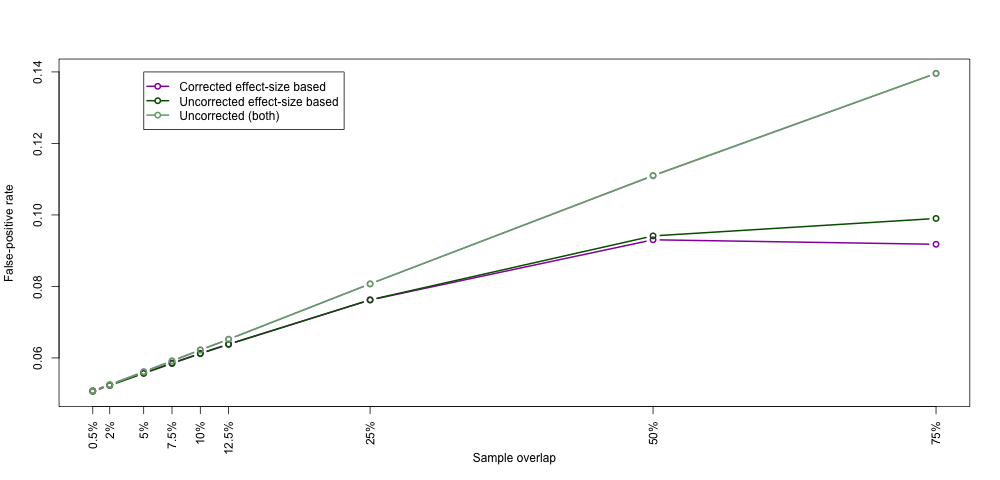

In [19]:
%%R -w 1000

#pdf("t1err_extensive_papercolors.pdf", width=10, height=6)
#tiff("fp.400.new.extended.tiff", res=400, width=10, height=6, units='in')
d=read.table("all.extra.t1err")

plot(x=ovlp, colMeans(d[,seq(1, ncol(d), by=4)]), type="b", ylim=c(0.05, 0.14), lwd=2, col=pal[1], main="", 
     xlab="Sample overlap", ylab="False-positive rate", xaxt="n")
lines(x=ovlp, colMeans(d[,seq(2, ncol(d), by=4)]), type="b", lwd=2, col=pal[2])
lines(x=ovlp, colMeans(d[,seq(3, ncol(d), by=4)]), type="b", lwd=2, col=pal[4])
lines(x=ovlp, colMeans(d[,seq(4, ncol(d), by=4)]), type="b", lwd=2, col=pal[3])
axis(1, at=ovlp, labels=c("0.5%", "2%", "5%", "7.5%", "10%", "12.5%", "25%", "50%", "75%"), las=3)
legend(100, 0.14, c("Corrected effect-size based", "Uncorrected effect-size based",  "Uncorrected (both)"), 
       col=pal[c(1,4,3)], pch=21, pt.bg="white", lwd=2)
#dev.off()

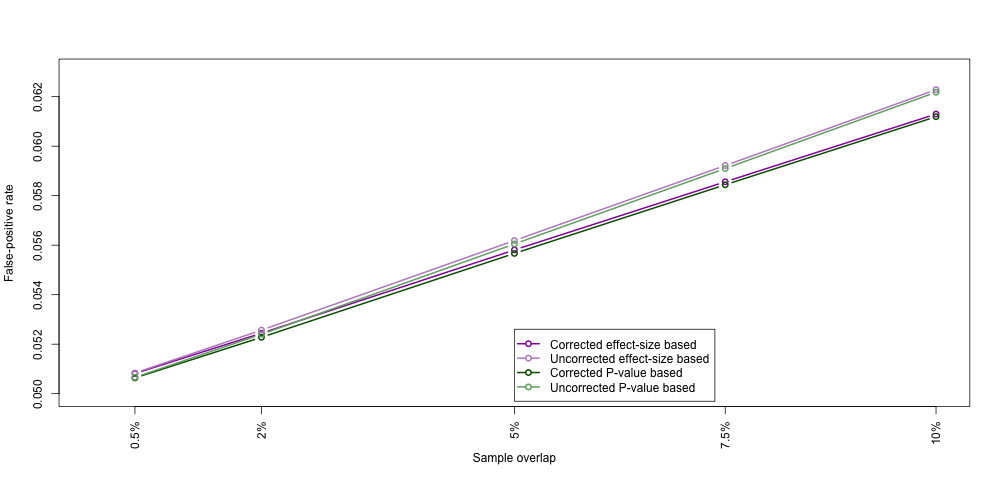

In [20]:
%%R -w 1000
#par(mfrow=c(1,2))
#pdf("power_square_papercolors.pdf")
#tiff("fp.400.new.tiff", res=400, width=8, height=8, units='in')

d=as.data.frame(read.table("all.extra.t1err"))
#pal=adjustcolor(pal, alpha=1)
d=d[,1:20]
ovlp=c(10, 40, 100, 150, 200, 250, 500, 1000, 1500)
ovlp=ovlp[1:5]
lci=apply(d, 2, function(x) t.test(x)$conf.int[1])
uci=apply(d, 2, function(x) t.test(x)$conf.int[2])

plot(x=ovlp, colMeans(d[,seq(1, ncol(d), by=4)]), type="b", ylim=c(0.05, 0.063), xlim=c(0,200), 
     lwd=2, col=pal[1], main="", xlab="Sample overlap", ylab="False-positive rate", xaxt="n")


lines(x=ovlp, colMeans(d[,seq(2, ncol(d), by=4)]), type="b", lwd=2, col=pal[2])
lines(x=ovlp, colMeans(d[,seq(3, ncol(d), by=4)]), type="b", lwd=2, col=pal[4])
lines(x=ovlp, colMeans(d[,seq(4, ncol(d), by=4)]), type="b", lwd=2, col=pal[3])
axis(1, at=ovlp, labels=c("0.5%", "2%", "5%", "7.5%","10%", "12.5%", "25%", "50%", "75%")[1:5], las=3)
legend(100, 0.0526, c("Corrected effect-size based", "Uncorrected effect-size based", 
                      "Corrected P-value based", "Uncorrected P-value based"), 
       col=pal[c(1,2,4,3)], pch=21, pt.bg="white", lwd=2)


#dev.off()

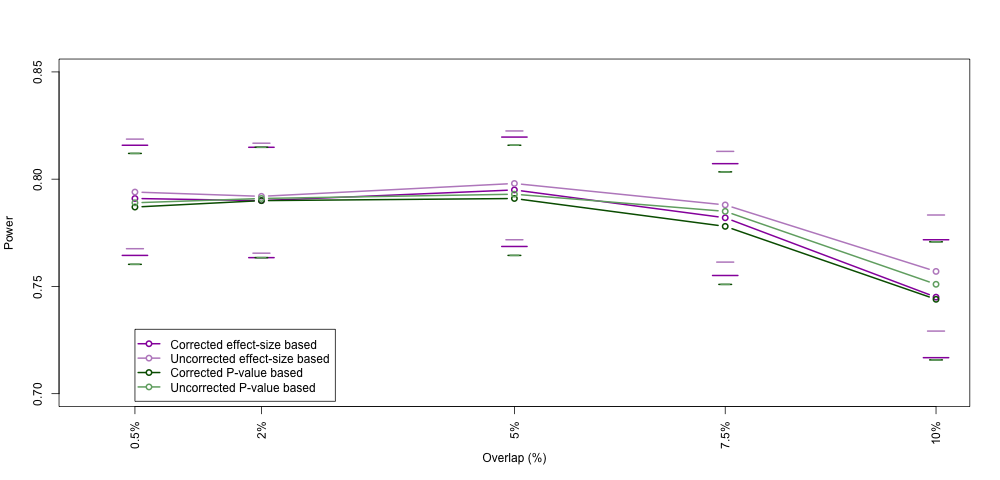

In [17]:
%%R -w 1000
#pdf("t1err_square_papercolors.pdf")
#tiff("pwr.400.new.tiff", res=400, width=8, height=8, units='in')
#dev.new()

pal=c("#823960","#BD9AAA","#91AA91","#1C5F1D")
pal=c("#683071","#AC97B1","#8BA48B","#045306")
pal=c("#9800AB","#BD8DC7","#71AB72","#005C00")
d=read.table("all.extra.pvalues")
ovlp=c(10, 40, 100, 150, 200, 250, 500, 1000, 1500)
pwr=apply(d, 2, function(x) length(x[x<5e-8 & !is.na(x)])/length(x[!is.na(x)]))
lci=apply(d, 2, function(x) binom.test(length(x[x<5e-8 & !is.na(x)]), length(x[!is.na(x)]))$conf.int[1])
uci=apply(d, 2, function(x) binom.test(length(x[x<5e-8 & !is.na(x)]), length(x[!is.na(x)]))$conf.int[2])
pwr=pwr[1:(5*4)]
ovlp=ovlp[1:5]
plot(x=ovlp, y=pwr[seq(1, length(pwr), by=4)], type="b", xlim=c(0,200), lwd=2, col=pal[1], ylim=c(0.7, 0.85),
     xlab="Overlap (%)", xaxt="n", ylab="Power", main="")
segments(x0=ovlp-3, x1=ovlp+3, y0=lci[seq(1, length(pwr), by=4)], lwd=2, col=pal[1])
segments(x0=ovlp-3, x1=ovlp+3, y0=uci[seq(1, length(pwr), by=4)], lwd=2, col=pal[1])
lines(x=ovlp, y=pwr[seq(2, length(pwr), by=4)], type="b", lwd=2, col=pal[2])
segments(x0=ovlp-2, x1=ovlp+2, y0=lci[seq(2, length(pwr), by=4)], lwd=2, col=pal[2])
segments(x0=ovlp-2, x1=ovlp+2, y0=uci[seq(2, length(pwr), by=4)], lwd=2, col=pal[2])

lines(x=ovlp, y=pwr[seq(3, length(pwr), by=4)], type="b", lwd=2, col=pal[4])
segments(x0=ovlp-1.5, x1=ovlp+1.5, y0=lci[seq(3, length(pwr), by=4)], lwd=2, col=pal[4])
segments(x0=ovlp-1.5, x1=ovlp+1.5, y0=uci[seq(3, length(pwr), by=4)], lwd=2, col=pal[4])

lines(x=ovlp, y=pwr[seq(4, length(pwr), by=4)], type="b", lwd=2, col=pal[3])
segments(x0=ovlp-1, x1=ovlp+1, y0=lci[seq(3, length(pwr), by=4)], lwd=2, col=pal[3])
segments(x0=ovlp-1, x1=ovlp+1, y0=uci[seq(3, length(pwr), by=4)], lwd=2, col=pal[3])

axis(1, at=ovlp, labels=c("0.5%", "2%", "5%", "7.5%","10%", "12.5%", "25%", "50%", "75%")[1:5], las=3)
legend(10, 0.73, c("Corrected effect-size based", 
                   "Uncorrected effect-size based", "Corrected P-value based", "Uncorrected P-value based"), 
       col=pal[c(1,2,4,3)], pch=21, pt.bg="white", lwd=2)


#dev.off()


In [16]:
%%bash
convert -compress lzw pwr.400.new.tiff pwr.400.new.lzw.tiff
convert -compress lzw fp.400.new.tiff fp.400.new.lzw.tiff
convert -compress lzw pwr.400.new.extended.tiff pwr.400.new.extended.lzw.tiff
convert -compress lzw fp.400.new.extended.tiff fp.400.new.extended.lzw.tiff

bash: line 1: convert: command not found
bash: line 2: convert: command not found
bash: line 3: convert: command not found
bash: line 4: convert: command not found
